## Resources

https://www.youtube.com/watch?v=nKCT-Cdk0xY

https://academic.oup.com/bioinformatics/article/36/10/3286/5727756

## Generative model


In [6]:
n_pairs = 9
n_odds = 5
n_socks_types = n_pairs + n_odds

14

In [2]:
paired_socks = sort(repeat([1:n_pairs;], 2))
odds_socks = [n_pairs+1:n_pairs+n_odds;]
socks = vcat(paired_socks, odds_socks)

23-element Array{Int64,1}:
  1
  1
  2
  2
  3
  3
  4
  4
  5
  5
  6
  6
  7
  7
  8
  8
  9
  9
 10
 11
 12
 13
 14

In [9]:
using StatsBase

sample(socks, 3, replace=false)

3-element Array{Int64,1}:
 7
 9
 5

In [25]:
function pick_socks(;n_pairs=1, n_odd=1, n_pick=1)
    paired_socks = sort(repeat([1:n_pairs;], 2))
    odds_socks = [n_pairs+1:n_pairs+n_odd;]
    socks = vcat(paired_socks, odds_socks)
    @assert n_pick <= n_odd + 2*n_pairs
    return sample(socks, n_pick, replace=false)
end

pick_socks (generic function with 1 method)

In [26]:
pick_socks(n_pairs=9, n_odd=5, n_pick=11)

11-element Array{Int64,1}:
  1
 12
  8
  2
  5
  3
 14
  1
  5
  8
  6

## Prior distributions

In [11]:
using Distributions
using Plots

r, p = 30, 0.5

d = NegativeBinomial(r, p)
println("mean: $(mean(d)), std: $(std(d))")

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


mean: 30.0, std: 7.745966692414834


In [12]:
n_socks_prior = NegativeBinomial(30, 0.5)
prop_pairs_prior = Beta(15, 2)

Beta{Float64}(α=15.0, β=2.0)

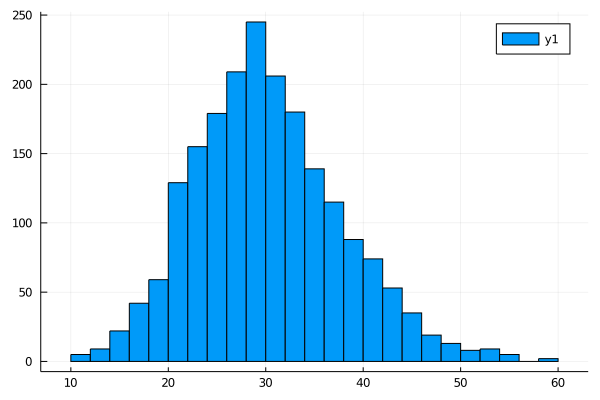

In [22]:
h = histogram(rand(n_socks_prior, 2000))
display(h)

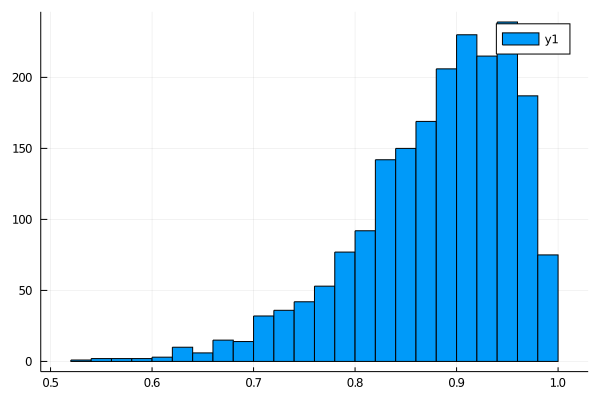

In [18]:
histogram(rand(prop_pairs_prior, 2000))

## Perform ABC

35.748335291813554


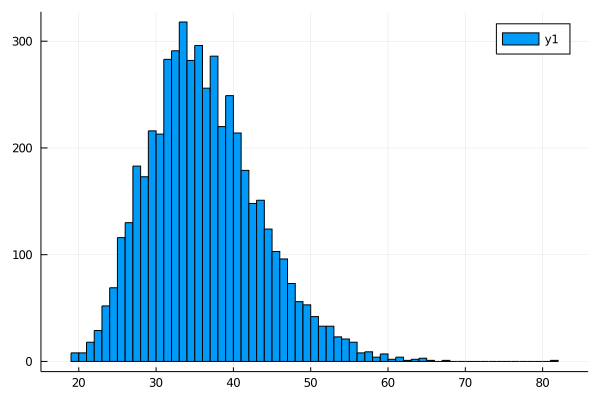

In [27]:
using StatsBase

function simulation(;niter=10)
    n_socks_prior = NegativeBinomial(30, 0.5)
    prop_pairs_prior = Beta(15, 2)
    n_pick = 11
    
    posterior = []
    
    for i = 1:niter
        # sample one value from each of the priors
        n_socks = rand(n_socks_prior)
        prop_pairs = rand(prop_pairs_prior)

        # println("n_socks=$n_socks, prop_pairs=$prop_pairs")
        n_pairs = Int(round(floor(n_socks/2)*prop_pairs))
        n_odd = n_socks - n_pairs * 2
        # println("n_pairs=$n_pairs, n_odd=$n_odd")
        n_sock_types = n_pairs + n_odd
        
        if n_pick > n_odd + 2n_pairs
            continue
        end

        # run experiment
        picked_socks = pick_socks(n_pairs=n_pairs, n_odd=n_odd, n_pick=n_pick)

        # compute metric: count the number of unique socks
        sock_counts = StatsBase.countmap(picked_socks)
        aux = StatsBase.countmap(collect(values(sock_counts)))
        # println(aux)
        unique = get(aux, 1, 0)
        pairs = get(aux, 2, 0)
        # println("unique=$unique, pairs=$pairs")
        @assert unique + 2*pairs == n_pick
        
        # accept or reject experiment
        if unique == 11
            append!(posterior, n_socks)
        end
    end
    
    return posterior
    
end

posterior = simulation(niter=50000)
println(mean(posterior))
histogram(posterior, bins=100)